# Import des bibliothèques

In [23]:
#importations de bibliothèques 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
# chargement des deux tables de la base de données
orders_distance_stores_softmax = pd.read_csv("orders_distance_stores_softmax.csv")
orders_products__prior_specials = pd.read_csv("order_products__prior_specials.csv")

In [3]:
orders_distance_stores_softmax

,Unnamed: 0,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,210,0,2.304404,1438665,prior,9,1,18,3.0
1,1,210,0,2.304404,2850206,prior,36,0,7,2.0
2,2,210,0,2.304404,2406913,prior,42,0,8,3.0
3,3,210,0,2.304404,1155933,prior,43,2,23,2.0
4,4,210,0,2.304404,271697,prior,56,5,17,3.0
...,...,...,...,...,...,...,...,...,...,...
136021,136021,206105,9,2.140636,1841888,prior,39,0,21,1.0
136022,136022,206105,9,2.140636,1137676,prior,43,4,15,1.0
136023,136023,206105,9,2.140636,1439511,prior,45,6,9,1.0
136024,136024,206105,9,2.140636,1783607,prior,58,4,19,0.0


In [4]:
orders_products__prior_specials

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,special
0,0,15,19660,1,1,15
1,1,15,21195,2,1,0
2,2,15,7461,3,1,50
3,3,15,2996,4,1,0
4,4,15,32463,5,1,0
...,...,...,...,...,...,...
1172307,1172307,3421069,21137,8,1,0
1172308,1172308,3421069,30391,9,1,15
1172309,1172309,3421069,18656,10,1,0
1172310,1172310,3421069,26940,11,1,15


## Concaténation des deux tables

In [5]:
# Obtenir l'ensemble des noms de colonnes uniques
colonnes_uniques = set(orders_distance_stores_softmax.columns).union(set(orders_products__prior_specials.columns))

Pour la concaténation, nous avons utilisé la méthode "merge" en se basant sur l'attribut commun des deux tables "order_id". Nous avons fixé la méthode de jointure à "inner" pour obtenir uniquement les lignes qui ont des correspondances dans les deux tables. 

In [6]:
#combiner les deux tables de la base de données
data = orders_products__prior_specials.merge(orders_distance_stores_softmax, on='order_id', how='inner', suffixes=('', '_dup'))


In [7]:
data.shape

(1172312, 15)

In [8]:
data.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,special,Unnamed: 0_dup,user_id,store_id,distance,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,15,19660,1,1,15,37332,54901,1,0.304608,prior,51,3,11,2.0
1,1,15,21195,2,1,0,37332,54901,1,0.304608,prior,51,3,11,2.0
2,2,15,7461,3,1,50,37332,54901,1,0.304608,prior,51,3,11,2.0
3,3,15,2996,4,1,0,37332,54901,1,0.304608,prior,51,3,11,2.0
4,4,15,32463,5,1,0,37332,54901,1,0.304608,prior,51,3,11,2.0


Notre ensemble de données contient 1172312 et 15 colonnes dont les colonnes "Unnamed". Nous allons les supprimer (non pertinents pour notre étude).

In [9]:
data = data.drop(columns=['Unnamed: 0', 'Unnamed: 0_dup'])

In [10]:
data.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'special',
       'user_id', 'store_id', 'distance', 'eval_set', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

Nous avons donc 13 attributs donc l'attribut à prédire "reordered". Nous allons afficher le nombre d'échantillons pour chaque classe de l'attribut. Cette information sera pertinente pour l'analyse des résultats de prédiction. En cas de déséquilibre, il faut choisir des métriques spécifiques comme F1.

In [11]:
data['reordered'].value_counts()

reordered
1    907879
0    264433
Name: count, dtype: int64

## Réduction des données (5%)

Avant de réduire nos données, nous allons les pourcentages des valeurs manquantes pour optimiser notre nouvel sous-ensemble.

In [12]:
# Calcul de la moyenne des valeurs manquantes pour chaque colonne
pourcentage_valeurs_manquantes = (data.isnull().mean() * 100).round(2)

# Convertir le résultat en DataFrame pour une meilleure présentation
tableau_pourcentage_valeurs_manquantes = pd.DataFrame(pourcentage_valeurs_manquantes, columns=['Pourcentage de valeurs manquantes'])

tableau_pourcentage_valeurs_manquantes

,Pourcentage de valeurs manquantes
order_id,0.00
product_id,0.00
add_to_cart_order,0.00
reordered,0.00
special,0.00
user_id,0.00
store_id,0.00
distance,0.00
eval_set,0.00
order_number,0.00


Puisque nous avons plus de 1 milions de lignes (échantillons), nous nous permettons de supprimer les lignes où la valeur 'days_since_prior_order' est manquante.

In [13]:
# Suppression des lignes où 'days_since_prior_order' est null
data = data.dropna(subset=['days_since_prior_order'])

Pour générer un sous ensemble de 5% des données, nous avons utilisé la méthode "train_test_split". Nous avons fait une stratification par rapport au "user_id" parce que notre prédiction de l'attribut "reordered" concerne aussi l'utilisateur (s'il a refait la même commande) donc nous avons voulu assurer qu'il y a un nombre équilibré et varié des utilisateurs (et leurs commandes).

In [14]:
# stratification avec les IDs des utilisateurs
_, sampled_df = train_test_split(data, test_size=0.05, stratify=data['user_id'], random_state=42)

# Sous ensemble obtenu
print(sampled_df.columns)

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'special',
       'user_id', 'store_id', 'distance', 'eval_set', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')


In [15]:
sampled_df.shape

(57923, 13)

Notre sous-ensemble contient 57923 échantillons et 12 prédicteurs.

In [16]:
#afficher quelques statistiques sur les attributs du sous ensemble obtenu
sampled_stats = sampled_df.describe()
print(sampled_stats)

           order_id    product_id  add_to_cart_order     reordered  \
count  5.792300e+04  57923.000000       57923.000000  57923.000000   
mean   1.713446e+06  25550.798180           7.295478      0.785370   
std    9.883998e+05  14045.228704           6.639979      0.410569   
min    1.280000e+02      1.000000           1.000000      0.000000   
25%    8.591580e+05  13541.000000           3.000000      1.000000   
50%    1.716721e+06  25133.000000           5.000000      1.000000   
75%    2.568789e+06  38003.000000          10.000000      1.000000   
max    3.421004e+06  49683.000000          96.000000      1.000000   

            special        user_id      store_id      distance  order_number  \
count  57923.000000   57923.000000  57923.000000  57923.000000  57923.000000   
mean       9.684927  101105.016177      4.522090      1.255326     50.216719   
std       14.920545   60524.234873      2.863444      0.659718     28.785013   
min        0.000000     210.000000      0.000000 

Nous allons vérifier qu'il y a un nombre raisonnable des commandes par utilisateur.

In [17]:
# Calcul de la taille de chaque groupe d'user_id
group_sizes = sampled_df.groupby('user_id').size()

# Tentative d'afficher tous les résultats
# print(group_sizes.to_string())

In [18]:
user_id = group_sizes.index.to_numpy()
user_id = np.reshape(user_id, (user_id.shape[0], 1))
values = group_sizes.to_numpy()
values = np.reshape(values, (values.shape[0], 1))
distributions = pd.DataFrame(np.hstack((user_id, values)), columns=["user_id", "values"])

<Axes: title={'center': 'Distributions de la representativité des utilisateurs'}, xlabel='User'>

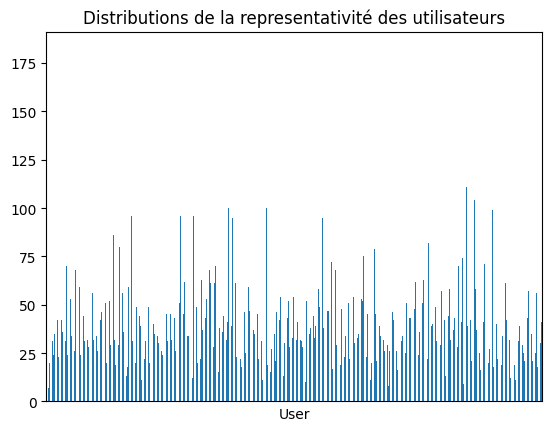

In [19]:
distributions.plot.bar(x="user_id",
                    y="values", 
                    xlabel="User", 
                    xticks=[], 
                    title="Distributions de la representativité des utilisateurs",
                    legend=None,
                    )

## Préparation des données 

Encodage des variables catégorielles (eval_set)

In [20]:
# Initialisation du LabelEncoder
label_encoder = LabelEncoder()

# Identification des colonnes catégorielles
variables_categorielles = sampled_df.select_dtypes(include=['object', 'category']).columns

# Boucle sur chaque colonne catégorielle pour appliquer le LabelEncoder directement sur la colonne originale
for col in variables_categorielles:
    # Application du LabelEncoder à la colonne et écrasement de la colonne originale avec la version encodée
    sampled_df[col] = label_encoder.fit_transform(sampled_df[col])

In [21]:
sampled_df.head()

,order_id,product_id,add_to_cart_order,reordered,special,user_id,store_id,distance,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
760490,2217474,42265,5,1,30,110129,8,2.275611,0,18,0,9,13.0
841198,2451110,19364,2,0,30,5329,2,1.016294,0,23,4,19,0.0
295601,864357,9666,2,1,0,202153,1,2.285474,0,18,1,8,3.0
236126,692655,39636,14,1,0,6448,6,2.565797,0,96,3,11,2.0
917938,2676822,14118,5,1,0,67736,5,0.963877,0,35,1,14,5.0


In [22]:
sampled_df.nunique()

order_id                  43983
product_id                 9946
add_to_cart_order            81
reordered                     2
special                       4
user_id                    1374
store_id                     10
distance                  12666
eval_set                      1
order_number                 98
order_dow                     7
order_hour_of_day            24
days_since_prior_order       31
dtype: int64

Nous remarquons que "eval_set" a une seule valeur.

In [23]:
sampled_df['eval_set'].dtype

dtype('int32')

Nous allons convertir les valeurs de l'attribut 'order_hour_of_day' pour qu'elles aient la même unité que l'attribut 'days_since_prior_order'. Nous voulons que les deux attributs soient exprimés en jours.

In [24]:
# Convertir les heures en jours (1 jour = 24 heures) pour 'order_hour_of_day'
sampled_df['order_hour_of_day'] = sampled_df['order_hour_of_day'] / 24

## Vérification des valeurs dupliquées

In [25]:
duplicates_df = sampled_df[sampled_df.duplicated()]
duplicates_df_sorted = duplicates_df.sort_values(by=['order_id'])
print(f"Nombre de valeurs dupliquées dans nos données \n{duplicates_df_sorted.sum()}")

Nombre de valeurs dupliquées dans nos données 
order_id                  0.0
product_id                0.0
add_to_cart_order         0.0
reordered                 0.0
special                   0.0
user_id                   0.0
store_id                  0.0
distance                  0.0
eval_set                  0.0
order_number              0.0
order_dow                 0.0
order_hour_of_day         0.0
days_since_prior_order    0.0
dtype: float64


Dans cette partie, nous avons vérifié que nos échantillons ne soient pas dupliqués.

## Visualisation des données 

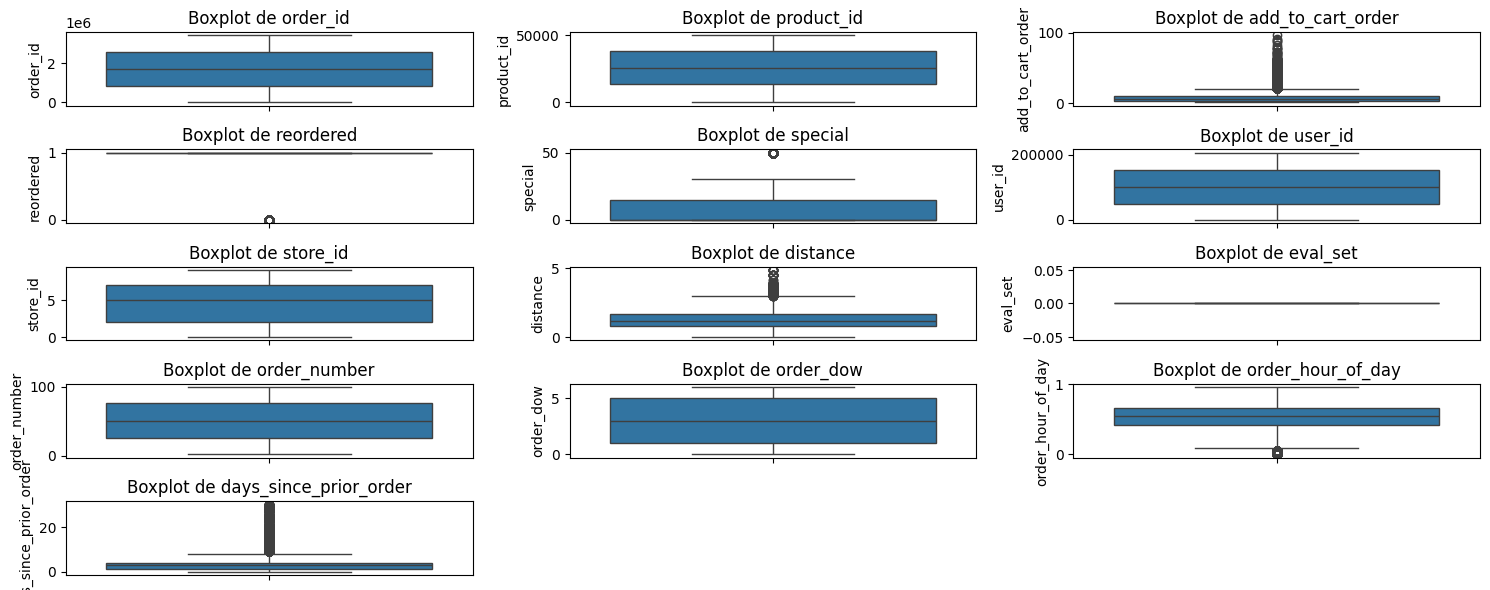

In [26]:
# Sélection des colonnes numériques
colonnes_numeriques = sampled_df.select_dtypes(include=['float64', 'int64', 'int32']).columns

# Définition de la taille de la grille
n_cols = 3
n_rows = int(np.ceil(len(colonnes_numeriques) / n_cols))

# Création des figures de boxplot avec ajustement de la taille
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6))  # Ajustez la largeur et la hauteur selon vos préférences
axes = axes.flatten()

for i, col in enumerate(colonnes_numeriques):
    sns.boxplot(y=sampled_df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_ylabel(col)

# Masquer les axes supplémentaires s'il y en a
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Analyse des visualisations des boxplots : 

Boxplot de store_id : Les identifiants de magasin montrent une certaine variabilité, mais la distribution est centrée, ce qui indique que les commandes proviennent d'un groupe relativement cohérent de magasins.

Boxplot de order_number : Les numéros de commande semblent avoir une distribution étendue avec la médiane vers le bas de la gamme, ce qui pourrait indiquer que de nombreux utilisateurs sont dans les premières étapes de l'historique de commande.

Boxplot de days_since_prior_order : Cette variable a une médiane proche de 0 avec des valeurs étendues vers le haut, ce qui indique des variations dans le temps écoulé depuis la dernière commande.

Boxplot de product_id : Les identifiants de produit sont distribués sur une large gamme avec quelques valeurs aberrantes, ce qui indique une grande variété de produits commandés.

Boxplot de special : Cette variable a une médiane à 0 et quelques valeurs aberrantes, ce qui suggère que des offres spéciales ne sont appliquées que dans un nombre limité de cas.

Boxplot de distance : Il y a des valeurs aberrantes, ce qui indique que bien que la plupart des utilisateurs soient à une distance moyenne des magasins, certains sont nettement plus éloignés.

Boxplot de order_dow : La distribution semble régulière sur toute la semaine sans valeurs aberrantes, suggérant une tendance uniforme dans les jours de passation des commandes.

Boxplot de add_to_cart_order : Il y a une grande variété dans l'ordre d'ajout des produits au panier, avec de nombreuses valeurs aberrantes, ce qui pourrait indiquer que certains produits ont tendance à être ajoutés au panier avant d'autres.

Boxplot de user_id : Les identifiants d'utilisateur ont une large distribution, ce qui suggère une grande base d'utilisateurs.

Boxplot de eval_set : Le boxplot n'est pas informatif ici puisque l'attribut contient une seule valeur.

Boxplot de order_hour_of_day : La distribution des heures de commande est centrée avec quelques valeurs aberrantes, indiquant des moments privilégiés pour passer commande au cours de la journée.

## Feature Engineering 

Dans ce contexte de ce tp, vous souhaitez prédire si un produit sera réordonné (reordered étant la variable cible) dans une future commande en fonction de l'historique d'achat d'un utilisateur. Basé sur cette objectif, voici les attributs que nous pensons ne pas avoir de valeur ajoutée pour la prédiction et donc être des candidats à l'élimination :

- order_id : C'est un identifiant unique pour chaque commande, il n'aide pas directement à prédire le réordonnancement. 

- eval_set : Il s'agit simplement d'une variable technique indiquant l'appartenance des données à un ensemble d'entraînement, de validation ou de test et qui garde la même valeur pour toutes les échantillons de notre ensemble de données. Elle ne doit pas être incluse dans l'entraînement du modèle pour éviter la fuite de données.

- store_id : L'identifiant du magasin n'a pas de relation avec la probabilité de réordonner un produit, cet attribut est à écarter.

L'attribut "user_id" en soi n'est pas une caractéristique prédictive directe, mais il est essentiel pour grouper les données et générer des caractéristiques comportementales significatives au niveau de l'utilisateur qui peuvent grandement améliorer la performance de votre modèle de prédiction.

In [27]:
sampled_df = sampled_df.drop(columns = ['store_id', 'order_id', 'eval_set'])

## Division des données en ensembles Train et Test

In [28]:
X = sampled_df.drop('reordered', axis=1)  # Caractéristiques
y = sampled_df['reordered']  # Variable cible

# Séparation des données en ensemble d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
X_train.columns

Index(['product_id', 'add_to_cart_order', 'special', 'user_id', 'distance',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')

In [30]:
X_test.columns

Index(['product_id', 'add_to_cart_order', 'special', 'user_id', 'distance',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')

In [31]:
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

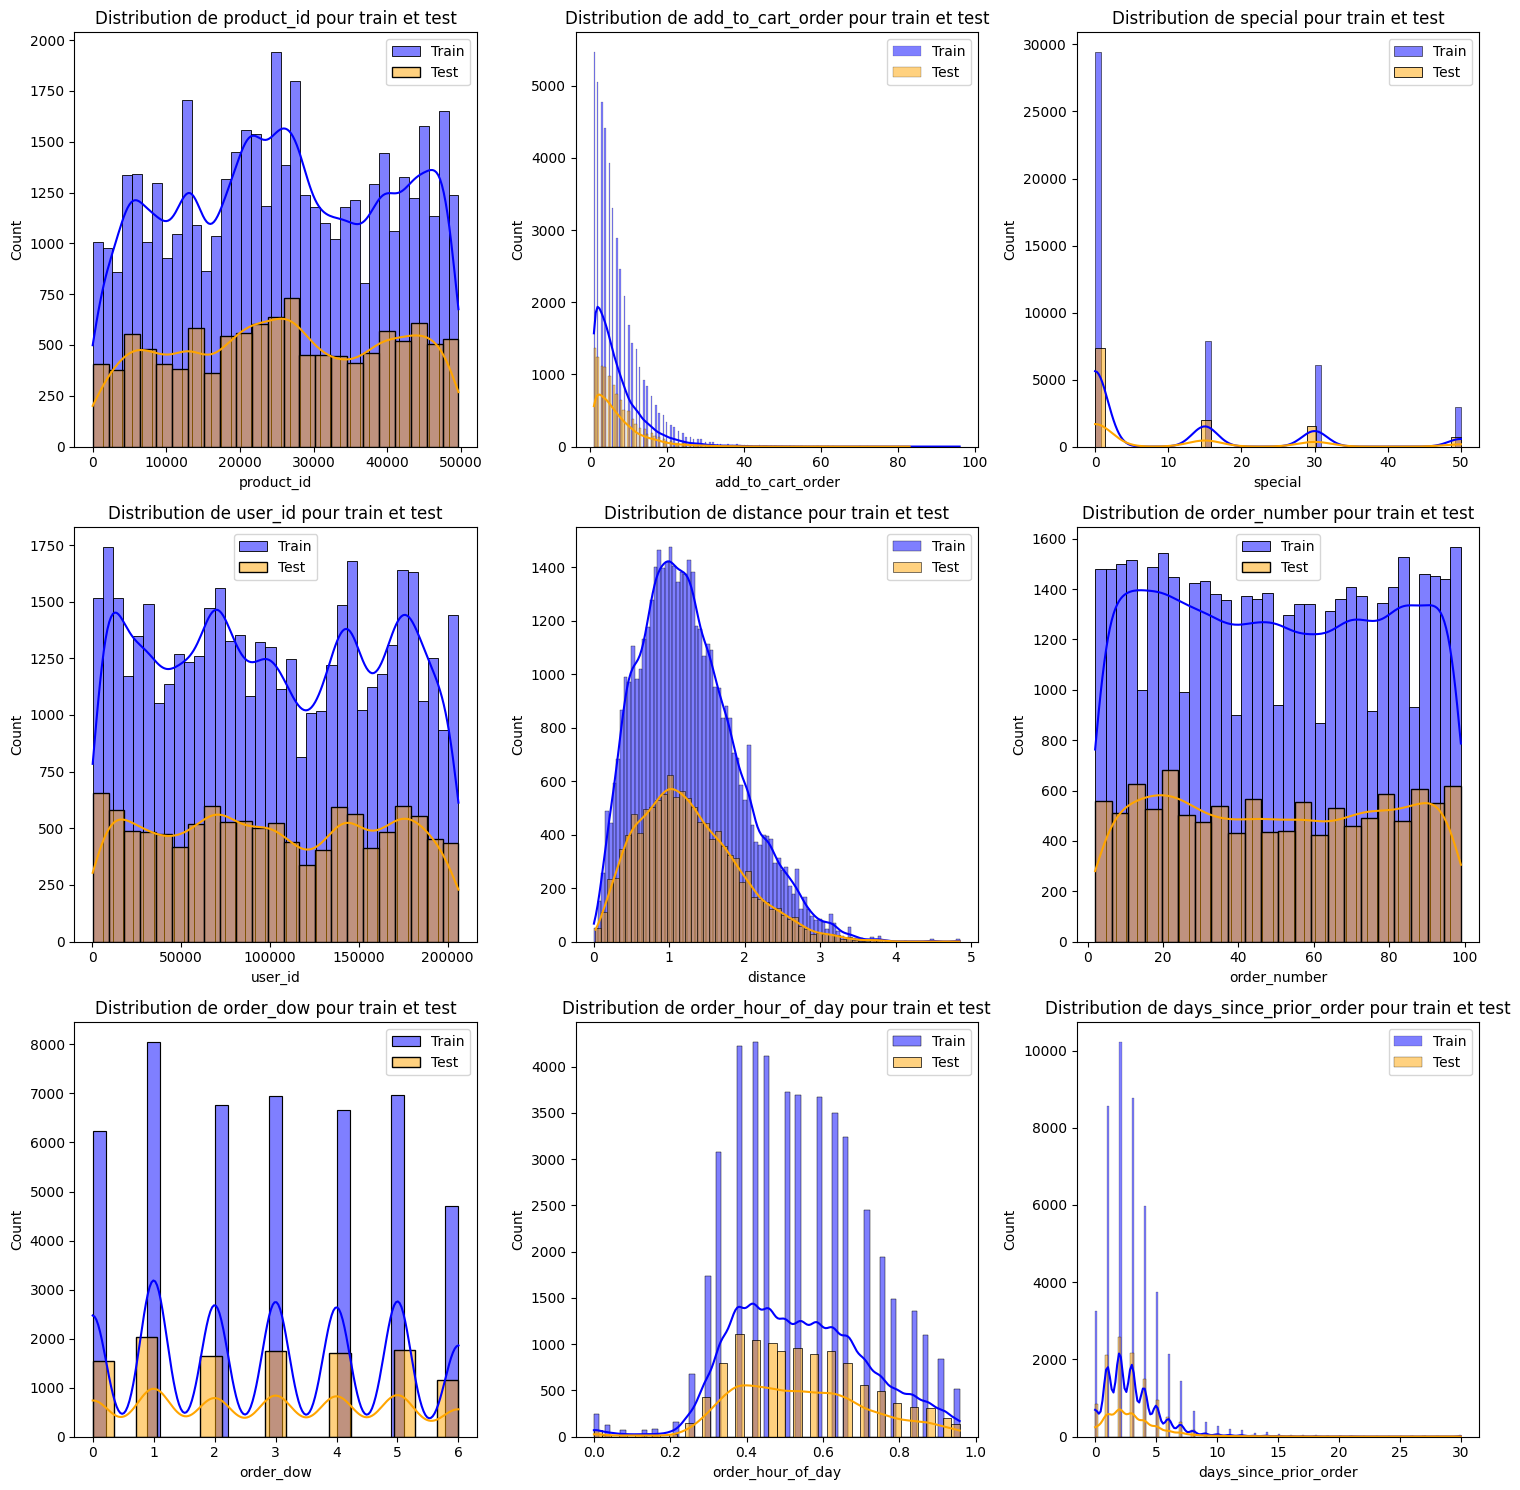

In [32]:
# Réglage des paramètres pour afficher 3 figures par ligne
n_cols = 3  # Nombre de colonnes par ligne dans la grille de subplots
n_rows = int(np.ceil(len(numeric_columns) / n_cols))  # Calcul du nombre de lignes nécessaires

# Création d'une figure et de subplots avec la grille spécifiée
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

# Aplatir le tableau d'axes pour une itération facile si nécessaire
axes_flat = axes.flatten()

# Visualisation avec des histogrammes pour chaque colonne numérique
for i, col in enumerate(numeric_columns):
    sns.histplot(X_train[col], color='blue', label='Train', kde=True, ax=axes_flat[i])
    sns.histplot(X_test[col], color='orange', label='Test', kde=True, ax=axes_flat[i])
    axes_flat[i].set_title(f'Distribution de {col} pour train et test')
    axes_flat[i].legend()

# Si le nombre total de colonnes numériques n'est pas un multiple de 3, masquer les axes vides
for j in range(i+1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.show()

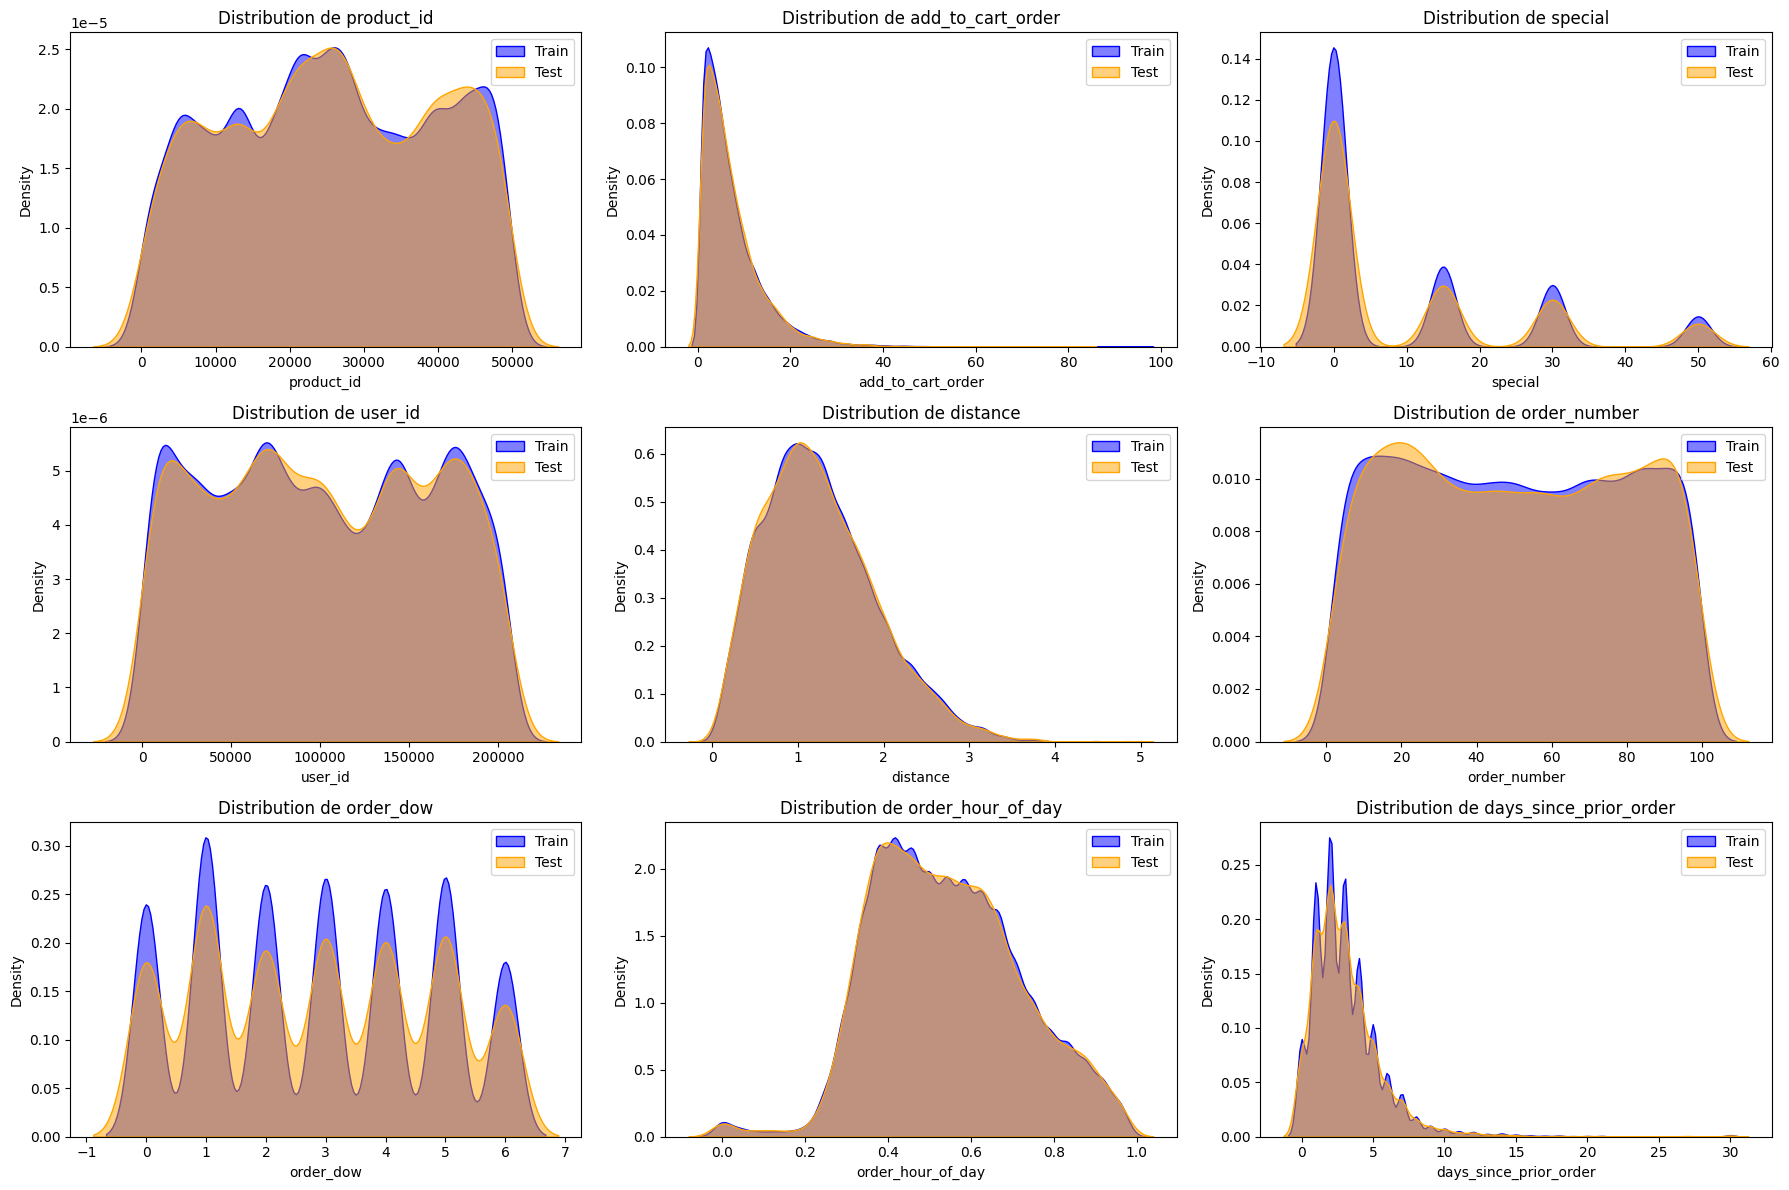

In [33]:
# Création d'une figure avec la grille de subplots pour des courbes de densité
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))

# Parcourir chaque colonne numérique et tracer des courbes de densité pour les ensembles train et test
for i, col in enumerate(numeric_columns):
    row = i // n_cols
    col_index = i % n_cols
    ax = axes[row, col_index]

    # Tracer la courbe de densité pour l'ensemble d'entraînement
    sns.kdeplot(data=X_train, x=col, fill=True, ax=ax, label='Train', color='blue', alpha=0.5)

    # Tracer la courbe de densité pour l'ensemble de test
    sns.kdeplot(data=X_test, x=col, fill=True, ax=ax, label='Test', color='orange', alpha=0.5)

    ax.set_title(f'Distribution de {col}')
    ax.legend()

# Cacher les subplots vides s'il y en a
for j in range(i+1, n_rows*n_cols):
    axes.flat[j].set_visible(False)

plt.tight_layout()
plt.show()

Les courbes montrent que les ensembles d'entraînement et de test ont des distributions cohérentes et comparables pour la majorité des attributs examinées. Cela signifie que la séparation des données a été bien réalisée, offrant ainsi une bonne représentativité et permettant d'anticiper que les modèles de machine learning entraînés sur l'ensemble d'entraînement devraient avoir des performances similaires sur l'ensemble de test. Les pics et creux correspondants dans les courbes de densité de product_id, add_to_cart_order, et days_since_prior_order reflètent des tendances spécifiques de comportement d'achat qui sont préservées entre les ensembles. Les caractéristiques périodiques comme order_dow et les pics d'heures dans order_hour_of_day sont particulièrement remarquables, révélant des schémas d'achat récurrents sur les jours et les heures qui pourraient être significatifs pour la prédiction du réordonnancement. En résumé, ces visualisations fournissent une confirmation visuelle que la séparation des données maintient l'intégrité statistique nécessaire pour une modélisation prédictive fiable.

# Sauvegarde des fichiers

In [34]:
# Pour les données d'entraînement
X_train.to_csv('x_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

# Pour les données de test
X_test.to_csv('x_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Pour sample_df
sampled_df.to_csv('final_data.csv', index=False)

# Entraînement des modèles (Question 2)

In [39]:
import pandas as pd

X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(46338, 9) (46338, 1) (11585, 9) (11585, 1)



Puisque la couche de sortie utilise deux neurones, nous devons lui fournir un vecteur binaire à deux dimensions, c'est-à-dire contenant soit 0 ou 1. Cependant, notre vecteur cible est unidimensionnel. Par conséquent, nous allons utiliser un encodeur OneHotEncoder pour le transformer en un vecteur avec les dimensions appropriées.

In [49]:
from sklearn.preprocessing import OneHotEncoder

y_train_ = y_train.to_numpy().reshape(-1, 1)
y_test_ = y_test.to_numpy().reshape(-1, 1)

enc = OneHotEncoder(sparse_output=False)
y_train_ = enc.fit_transform(y_train_)
y_test_ = enc.fit_transform(y_test_)
print(y_train_.shape, y_test_.shape)

(46338, 2) (11585, 2)


#### Implémentation du CNN

Nous allons mettre en place un modèle de réseau de neurones convolutionnel (CNN) comprenant deux couches cachées utilisant la fonction d'activation relu, ainsi qu'une couche de sortie softmax composée de deux neurones, chacun représentant l'une des deux classes cibles.

In [33]:
import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Sequential

In [50]:
model = Sequential()

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train_, epochs=50)

Epoch 1/50


1449/1449 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7015 - loss: 199.5442
Epoch 2/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7239 - loss: 53.8764
Epoch 3/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7313 - loss: 41.7517
Epoch 4/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7400 - loss: 26.2144
Epoch 5/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7314 - loss: 22.8501
Epoch 6/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7438 - loss: 15.8863
Epoch 7/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7372 - loss: 12.5715
Epoch 8/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7422 - loss: 8.2739
Epoch 9/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7395 - loss: 4.6501
Epoch 10/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7414 - loss: 2.1853
Epoch 11/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7430 - loss: 1.2266
Epoch 12/50
1449/1449 ━━━━━━━━━━━

In [52]:
test_loss, test_acc = model.evaluate(x=X_test, y=y_test_)

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7803 - loss: 0.5267


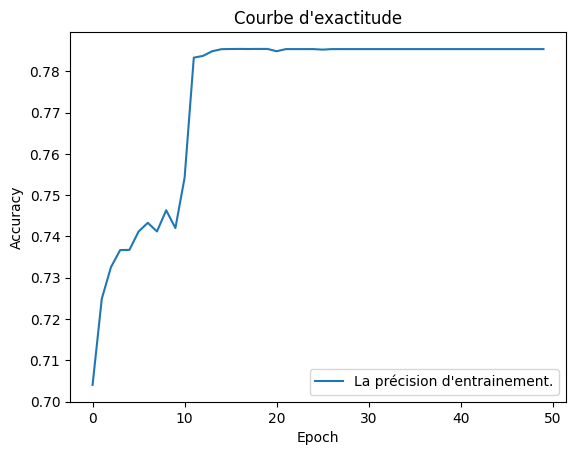

In [57]:
plt.plot(history.history['accuracy'], label="La précision d'entrainement.")
plt.title('Courbe d\'exactitude')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

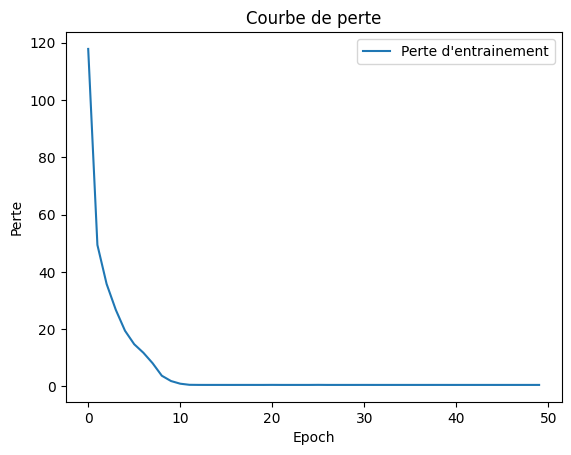

In [56]:
plt.plot(history.history['loss'], label="Perte d'entrainement")
plt.title('Courbe de perte')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()
plt.show()

### Implémentation SVM

Nous implémentons la méthode de classification Machine à vecteur de support, avec un gridsearch pour la recherche des meilleurs hyper-parametres (Le noyeau et la constante C).

In [58]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

parameters = {'kernel': ('poly', 'rbf'), 'C': [0.1, 1, 10]}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

print(clf.best_params_)

c:\Users\tasli\OneDrive\Usherbrooke\Forage_IFT-870\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_pred = clf.predict(X_test)

print("\nRapport de classification :")
print(classification_report(y_test, y_pred))